# Betting on Esports
## Modeling I
### Jonathan Pena
### Capstone Notebook Part 2
# Data Loading

After the EDA is complete, we now have a clean data set that can be used to build our model. We will build our first model in this notebook, which will be logistic regression. Using logistic regression, you can estimate the probability of a true or false outcome, here it is a win or a loss. We are trying to determine if the red team won or lost the game. The first step is to import the libraries that we will be using.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importing models
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score

# ignore future warnings
import warnings
warnings.filterwarnings('ignore')

We will load the clean dataset and double check the information.

In [2]:
# Loading the data into a dataframe.
lol_cleaned = pd.read_csv('data/lol_cleaned.csv').reset_index().drop(columns=['index', 'Unnamed: 0'])

# Convert 'Date' column to datetime type.
lol_cleaned['date'] = pd.to_datetime(lol_cleaned['date'])

In [3]:
# check some rows from the dataset
lol_cleaned.head()

,gameid,date,side,team,gamelength,result,kills,deaths,firstblood,dragons,barons,towers,wcpm,controlwardsbought,totalgold,minionkills,cspm
0,6909-9183,2021-01-09 09:22:04,Blue,Top Esports,2050,0,3,9,1.0,2.0,0.0,3.0,2.4293,40.0,54617,987.0,36.0000
1,6909-9183,2021-01-09 09:22:04,Red,Suning,2050,1,9,3,0.0,2.0,1.0,6.0,1.7854,46.0,60520,947.0,35.5610
2,6909-9184,2021-01-09 10:16:20,Blue,Top Esports,2241,0,16,27,0.0,3.0,2.0,6.0,1.9545,42.0,69692,957.0,33.2798
3,6909-9184,2021-01-09 10:16:20,Red,Suning,2241,1,27,17,1.0,2.0,0.0,7.0,1.4726,49.0,70269,939.0,31.8876
4,6910-9189,2021-01-09 11:30:25,Blue,Oh My God,1887,0,4,15,1.0,1.0,0.0,3.0,1.4944,32.0,51145,848.0,33.8951


In [4]:
# dataset shape
lol_cleaned.shape

(21652, 17)

# Match Dataset

We have a clean dataset, but we must fix the matches according to the `gameid`. Because of that, we will split the dataset in two: blue side and red side, and then join them by `gameid`.

In [5]:
# divide the clean dataset into red and blue side.
blue_df = lol_cleaned[lol_cleaned['side']=='Blue'].set_index('gameid')
red_df = lol_cleaned[lol_cleaned['side']=='Red'].set_index('gameid')

# join the blue_df and red_df into matches_df by the index that is the gameid
matches_df = blue_df.join(red_df, lsuffix='_blue', rsuffix='_red')
matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10826 entries, 6909-9183 to ESPORTSTMNT02/2151568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date_blue                10826 non-null  datetime64[ns]
 1   side_blue                10826 non-null  object        
 2   team_blue                10826 non-null  object        
 3   gamelength_blue          10826 non-null  int64         
 4   result_blue              10826 non-null  int64         
 5   kills_blue               10826 non-null  int64         
 6   deaths_blue              10826 non-null  int64         
 7   firstblood_blue          10826 non-null  float64       
 8   dragons_blue             10826 non-null  float64       
 9   barons_blue              10826 non-null  float64       
 10  towers_blue              10826 non-null  float64       
 11  wcpm_blue                10826 non-null  float64       
 12  controlwardsb

After joining the datasets we have some duplicate columns like `date_blue` and `date_red`, as well as some we don't need anymore, such as the side of the map. These will be removed.

In [6]:
# drop unnecessary columns
matches_df = matches_df.drop(columns=['date_blue', 'date_red', 'deaths_blue', 'deaths_red', 'result_blue', 'side_blue',
                                      'side_red', 'gamelength_red', 'gamelength_blue'])
# reset dataframe index
matches_df.reset_index(inplace=True)

# drop gameid column
matches_df.drop(columns=['gameid'], inplace=True)

# check some rows of the dataframe
matches_df.head()

,team_blue,gamelength_blue,kills_blue,firstblood_blue,dragons_blue,barons_blue,towers_blue,wcpm_blue,controlwardsbought_blue,totalgold_blue,minionkills_blue,cspm_blue,team_red,gamelength_red,result_red,kills_red,firstblood_red,dragons_red,barons_red,towers_red,wcpm_red,controlwardsbought_red,totalgold_red,minionkills_red,cspm_red
0,Top Esports,2050,3,1.0,2.0,0.0,3.0,2.4293,40.0,54617,987.0,36.0000,Suning,2050,1,9,0.0,2.0,1.0,6.0,1.7854,46.0,60520,947.0,35.5610
1,Top Esports,2241,16,0.0,3.0,2.0,6.0,1.9545,42.0,69692,957.0,33.2798,Suning,2241,1,27,1.0,2.0,0.0,7.0,1.4726,49.0,70269,939.0,31.8876
2,Oh My God,1887,4,1.0,1.0,0.0,3.0,1.4944,32.0,51145,848.0,33.8951,EDward Gaming,1887,1,15,0.0,4.0,1.0,9.0,1.8442,34.0,60738,910.0,36.4388
3,EDward Gaming,2010,8,0.0,1.0,0.0,2.0,1.5821,39.0,54258,891.0,33.0746,Oh My God,2010,1,18,1.0,4.0,1.0,11.0,1.2537,33.0,64618,915.0,34.2388
4,Oh My God,2159,8,1.0,3.0,0.0,3.0,1.2228,45.0,57889,892.0,32.0426,EDward Gaming,2159,1,16,0.0,3.0,1.0,9.0,1.7786,42.0,67747,985.0,34.4882


Now that we have our match dataset, we can start building our model. We kept `red_result` in the EDA notebook, which is going to be our target and will give us a baseline of 47% for guessing the red team will win.

# Modeling I

Our first model is going to be a logistic regression. For classifying categorical data, it is is one of the most basic but effective tools we have at our disposal.

In the first step, we separate our independent variable from our target that is the result for the red team: 1 if it is a win, 0 if it is a loss.

In [9]:
# Separate the data into X and y variables
# X is the data containing the independent variables.
# y is the target.  The dependent variable.
X = matches_df.drop(columns= ['result_red'])
y = matches_df['result_red']

Next, we will encode the teams with dummy variables and concatenate them with our X data frame. Finally, we remove the `team_blue` and `team_red` columns.

In [10]:
# create dummies for team_blue and team_red
team_blue_dummies = pd.get_dummies(X[['team_blue']]).drop(columns='team_blue_unknown team')
X = pd.concat([X, team_blue_dummies], axis=1)

team_red_dummies = pd.get_dummies(X[['team_red']]).drop(columns='team_red_unknown team')
X = pd.concat([X, team_red_dummies], axis=1)

# drop the columns that contains the team names
X = X.drop(columns=['team_blue', 'team_red'])

In [11]:
# Checking the shape of X
X.shape, y.shape

((10826, 981), (10826,))

Our X dataframe now contains the features of each game, and our y dataframe contains the game result for the red team. We will split both dataframes into train and test dataframes to build our model. 

In [12]:
# split the data in train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# sets shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7578, 981), (3248, 981), (7578,), (3248,))

Even though our target is balanced, we still use the stratify parameter to maintain balance. The train set makes up 70% of the total dataset, while the test set makes up 30%. Our next step is to fit the logistic regression model. Our model will be optimized with GridSearchCV and a pipeline to avoid any mistakes in handling data.  

In [13]:
# estimators for the pipe
estimators = [
    ('normalise', StandardScaler()),
    ('model',LogisticRegression)
]

pipe = Pipeline(estimators)

We will optimize C: the inverse of regularization strength. By default, the Logistic Regression solver is lbfgs and it only supports L2-penalty. We will also set the GridSearchCV cv parameter to 5 to perform a 5-fold cross validation.

In [23]:
# create a pamater grid for 3 different models
param_grid = [
            {
                'model':  [LogisticRegression()],
                'normalise': [StandardScaler()],
                'model__C': [0.01, 0.1, 1, 10, 100]
            }
] 

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2) 

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END model=LogisticRegression(), model__C=0.01, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(), model__C=0.01, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.01, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.01, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.01, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.1, normalise=StandardScaler(); total time=   0.4s
[CV] END model=LogisticRegression(), model__C=0.1, normalise=StandardScaler(); total time=   0.4s
[CV] END model=LogisticRegression(), model__C=0.1, normalise=StandardScaler(); total time=   0.4s
[CV] END model=LogisticRegression(), model__C=0.1, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(), model__C=0.1, no

In [24]:
# best estimator
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=1))])

GridSearchCV had 5 candidates, 5 values for C. We fitted each candidate five times, for a total of 25 fits using five-cross validation. We found that C=1 is the best hyperparameters for our model.

In [16]:
# score means for eac one of the test
fittedgrid.cv_results_['mean_test_score']

array([0.97994261, 0.98099828, 0.98284577])

We can see from the above that the highest Mean Validation score was obtained from a total of 25 fits with C=1. Now we will fit to the test set.

In [17]:
# fit to the test set
fittedgrid.score(X_test, y_test)

0.9836822660098522

Due to the number of features that are used to describe matches, we got a very high score in our test set. A model like this is only applicable to matches that are already over, but it cannot be used to predict future games. In the next notebook, we will develop features that will help us predict a future game.

However, even if this model cannot help us to predict future games, it still has some applications. This model could also be used by esport commentators to provide audience members with information such as probabilities for each team during the game. In this case, we can feed information into the model that has already passed to calculate the red team's chances of winning.

Using Pipelines and Grid Search, we can combine multiple transforms and estimators, and automate the selection of hyperparameters and the combination of steps to apply to each model. On the other hand, depending on the size of the data, it could be very computationally expensive and time-consuming.

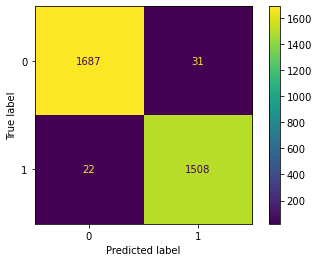

In [18]:
# plot confusion matrix
plot_confusion_matrix(fittedgrid, X_test, y_test);

### Based on our confusion matrix, we got the following four possible outcomes:
1. **True Positive (TP)**: Correctly predict that red team won. A total of 1508 points.
2. **False Positive (FP)**: Incorrectly predict that red team won. A total of 31 points.
3. **True Negative (TN)**: Correctly predict that red team lost. A total of 1687 points. 
4. **False Negative (FN)**: Incorrectly predict that red team lost. A total of 22 points.

It is interesting to note that despite having all the information to make our model, some False Positives and False Negatives still occurred. There are two ways to win a LoL match, either by destroying the Nexus of the other team or by forfeiting. As a result, we have some matches where even if one team performs better than the other during the whole game, it can still lose if it fails to achieve the final goal. These are called throwaway matches.

In the context of which class we prioritize to detect, we can select different scores to evaluate our model. For instance, if it is of greater interest to us to identify bad scores, we should reduce false positives and evaluate our model using precision scores. We can import the precision and recall scores from sklearn.metrics.

In [19]:
# print classification report
y_pred = fittedgrid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1718
           1       0.98      0.99      0.98      1530

    accuracy                           0.98      3248
   macro avg       0.98      0.98      0.98      3248
weighted avg       0.98      0.98      0.98      3248



Depending on our goal, we can choose one of these scores to make a better assessment of our model. Each score is different for our best model. Accuracy will be our top priority when predicting future games.

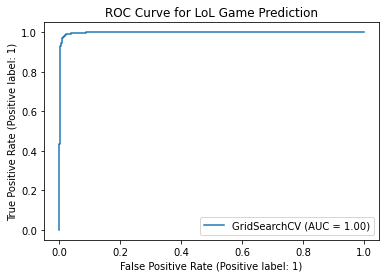

In [29]:
# plot ROC Curve
plot_roc_curve(fittedgrid, X_test, y_test)
plt.title('ROC Curve for LoL Game Prediction')
plt.show()

In [28]:
# AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.9837883387736158

According to the ROC curve and the AUC score, this model has a true positive rate close to 1. Very few outcomes were misclassified.

# Conclusion

In this notebook, we created a new dataframe in which a single data point contained information for both teams in the same game. Based on this dataframe, we developed a logistic regression model, one of the simplest classification models but effective for our goal. 

Our model achieved a very high score of almost 100%, which indicates it misclassified very few outcomes. The model is useful when we know the features of the current match. However, it cannot predict the winner of future matches because we need to know something about the actual match. During the game, esport commentators could use this model to provide audience members with information such as probabilities for each team. We can feed information into the model that has already passed to calculate the chances of the red team winning.

Next, we will perform feature engineering to create some features from past games that will help us predict future games.